In [91]:
# Run this block to install dependencies [Remember to make the statement true]
if 0 == 1:
    !pip3 install pandas
    !pip3 install tqdm
    !pip3 install scikit-learn
    !pip3 install gensim
    !pip3 install spacy
    !python3 -m spacy download en
    !pip3 install numpy

In [3]:
# Import W2V lib
from gensim.models.word2vec import Word2Vec

import pandas as pd
import spacy
import pickle
from tqdm import tqdm
from gensim.corpora import Dictionary
from sklearn.utils import shuffle
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

nlp = spacy.load('en')
DATA_LIMIT = 1000

df = pd.read_csv('./imdb_master.csv', encoding='latin1')
df_neg = df[df['label'] == 'neg']
df_pos = df[df['label'] == 'pos']
df = pd.concat((df_pos[:DATA_LIMIT], df_neg[:DATA_LIMIT]))
df_test = pd.concat((df_pos[DATA_LIMIT:1500], df_neg[DATA_LIMIT:1500]))

def process_text(input_string, return_string=False, stem=False):
    text = nlp(u'' + input_string)
    if stem == True:
        text = [tok.lemma_ for tok in text if (tok.is_alpha and not tok.is_stop)]
    else:
        text = [tok.lower_ for tok in text if (tok.is_alpha and not tok.is_stop)]
    if return_string == True:
        return " ".join(text)
    return text

In [4]:
# Make this statement true to run from scratch [It takes time to process the text]
if 1 != 0:
    wordlist = []
    for i in tqdm(range(df.shape[0])):
        wordlist.append(process_text(df['review'].iloc[i]))
        
    with open('vocabulary.txt', 'wb') as vocabulary:
        pickle.dump(wordlist, vocabulary)
    vocabulary.close()

100%|██████████| 2000/2000 [02:14<00:00, 14.83it/s]


In [29]:
# Load vocabulary
wordlist = []
with open('vocabulary.txt', 'rb') as vocabulary:
    wordlist = pickle.load(vocabulary)

In [95]:
# Keeping track of frequency of a single token
frequency = defaultdict(int)
for text in wordlist:
    for token in text:
        frequency[token] += 1
        
# Apply Threshold to limit the vocabulary size, discarding the tokens which appeard number of times below the threshold limit 
FREQ_THRESHOLD = 5

thresholded_wordlist =  [[token for token in text if frequency[token] > FREQ_THRESHOLD]
          for text in wordlist]

# Create Dictionary based on the word list
dictionary = Dictionary(thresholded_wordlist)

# Number of tokens
print("Number of Tokens - {}".format(len(dictionary)))
print(dictionary)
print(type(dictionary))
print(thresholded_wordlist[0])

Number of Tokens - 5464
Dictionary(5464 unique tokens: ['clear', 'moving', 'standards', 'understood', 'city']...)
<class 'gensim.corpora.dictionary.Dictionary'>
['i', 'went', 'saw', 'movie', 'night', 'friends', 'i', 'admit', 'i', 'i', 'knew', 'able', 'comedy', 'i', 'wrong', 'played', 'character', 'jake', 'kevin', 'played', 'ben', 'the', 'sign', 'good', 'movie', 'toy', 'emotions', 'this', 'exactly', 'the', 'entire', 'theater', 'sold', 'overcome', 'laughter', 'half', 'movie', 'moved', 'tears', 'second', 'half', 'while', 'theater', 'i', 'saw', 'women', 'tears', 'grown', 'men', 'trying', 'desperately', 'let', 'crying', 'this', 'movie', 'great', 'i', 'suggest', 'judge']


![image](https://i.imgur.com/f1uzTDZ.png)

# TODO

* From the screenshot you can see the implementation of word-cooccurance matrix, based on the tokens from the dictionary, build a word-cooccurance matrix yourself which is $X$. Documentation of gensim [https://radimrehurek.com/gensim/corpora/dictionary.html]
* Apply SVD on $X$
* Reduce Dimension 

![dimen_reduc](https://i.imgur.com/lezB870.png)

* Here Richard is taking only top two dimensions of the vector $U$, recommended size is *50* for now.

![dimen_reduc_u](https://i.imgur.com/TA2Bmsq.png)

* Now we can get a fixed size vector for each word. 

* Try to plot something similar based on the given dataset. In class we will try to implement a logistic regression classifier that can classify positive and negative reviews

In [112]:
X = np.zeros((len(dictionary), len(dictionary)))
# print(X.shape)

for word in thresholded_wordlist:
    
    idx = dictionary.doc2idx(word)
    
    for i in idx:
        for j in idx:
            X[i, j] += 1

# print(X)
np.fill_diagonal(X, 0)

In [115]:
print(X[1,0])

3.0


In [116]:
la = np.linalg
U, s, Vh = la.svd(X, full_matrices=False)

U_reduced = U[:, :50]

In [117]:
U_reduced.shape

(5464, 50)

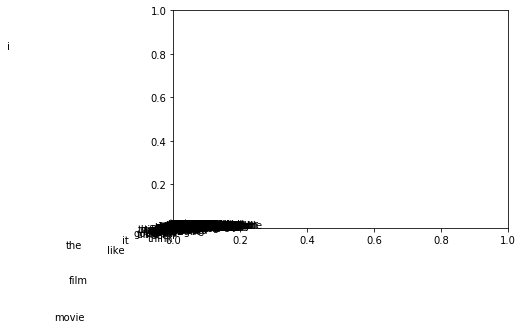

In [118]:
for i in range(len(dictionary)):
        plt.text(U[i, 0], U[i, 1], dictionary[i])

In [119]:
X_train = np.zeros([2000, 50])
for num, review in enumerate(thresholded_wordlist):
    vec = 0
    idx = dictionary.doc2idx(review)
    Ux = U_reduced[idx]
    X_train[num, :] += np.sum(Ux, axis=0)

print(X_train.shape)

(2000, 50)


In [120]:
y_train = np.where(df['label'] == "neg", 0, 1)

In [121]:
from sklearn.linear_model import LogisticRegression

logisticreg = LogisticRegression()
logreg = logisticreg.fit(X_train, y_train)

In [122]:
logreg.score(X_train, y_train)

0.864

In [127]:
#Making test data

y_test = np.where(df_test['label'] == 'neg', 0, 1)

In [125]:
if 1 != 0:
    wordlist_test = []
    for i in tqdm(range(df_test.shape[0])):
        wordlist_test.append(process_text(df_test['review'].iloc[i]))
        
    with open('vocabulary_test.txt', 'wb') as vocabulary:
        pickle.dump(wordlist_test, vocabulary)
    vocabulary.close()

100%|██████████| 1000/1000 [01:08<00:00, 14.53it/s]


In [126]:
# Load vocabulary
wordlist_test = []
with open('vocabulary_test.txt', 'rb') as vocabulary:
    wordlist_test = pickle.load(vocabulary)

In [128]:
frequency = defaultdict(int)
for text in wordlist_test:
    for token in text:
        frequency[token] += 1
        
# Apply Threshold to limit the vocabulary size, discarding the tokens which appeard number of times below the threshold limit 
FREQ_THRESHOLD = 5

thresholded_wordlist_test =  [[token for token in text if frequency[token] > FREQ_THRESHOLD]
          for text in wordlist_test]

# Create Dictionary based on the word list
dictionary = Dictionary(thresholded_wordlist_test)


X_test = np.zeros([1000, 50])
for num, review in enumerate(thresholded_wordlist_test):
    idx = dictionary.doc2idx(review)
    Ux_test = U_reduced[idx]
    X_test[num, :] += np.sum(Ux_test, axis=0)

print(X_test)

[[-3.36250142  1.57966846  0.22183352 ... -0.41246801 -0.14549921
   0.05411189]
 [-2.66737559  0.01817039 -0.14336702 ...  0.21287842  0.54081521
  -0.87790985]
 [-1.05857529 -0.3052493   0.14110925 ...  0.17072351 -0.22695934
  -0.47253189]
 ...
 [-0.87207706  0.70204862 -0.04736584 ...  0.10555553  0.01199151
   0.05280231]
 [-0.20337464 -0.06491143  0.03740263 ...  0.1380559  -0.11969993
  -0.20586635]
 [-1.10801848  0.61766196 -0.04998649 ...  0.18182879 -0.25932028
  -0.1723548 ]]


In [129]:
logreg_test = logisticreg.fit(X_test, y_test)
logreg_test.score(X_test, y_test)

0.716

# Word2Vec

In [31]:
# Import W2V lib
from gensim.models.word2vec import Word2Vec

import pandas as pd
import spacy
import pickle
from tqdm import tqdm
from gensim.corpora import Dictionary
from sklearn.utils import shuffle
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

nlp = spacy.load('en')
DATA_LIMIT = 1000

df = pd.read_csv('./imdb_master.csv', encoding='latin1')
df_neg = df[df['label'] == 'neg']
df_pos = df[df['label'] == 'pos']
df = pd.concat((df_pos[:DATA_LIMIT], df_neg[:DATA_LIMIT]))
df_test = pd.concat((df_pos[DATA_LIMIT:1500], df_neg[DATA_LIMIT:1500]))

def process_text(input_string, return_string=False, stem=False):
    text = nlp(u'' + input_string)
    if stem == True:
        text = [tok.lemma_ for tok in text if (tok.is_alpha and not tok.is_stop)]
    else:
        text = [tok.lower_ for tok in text if (tok.is_alpha and not tok.is_stop)]
    if return_string == True:
        return " ".join(text)
    return text

In [32]:
# Make this statement true to run from scratch [It takes time to process the text]
if 1 != 0:
    wordlist = []
    for i in tqdm(range(df.shape[0])):
        wordlist.append(process_text(df['review'].iloc[i]))
        
    with open('vocabulary.txt', 'wb') as vocabulary:
        pickle.dump(wordlist, vocabulary)
    vocabulary.close()

100%|██████████| 2000/2000 [02:18<00:00, 14.48it/s]


In [11]:
import multiprocessing

# hs = Hierarchical softmax, min_count -> excludes token less than that frequency)
w2v_model = Word2Vec(window=5, workers=multiprocessing.cpu_count(), iter=100, min_count=1, hs = 1, negative=0)

In [12]:
print(w2v_model)

Word2Vec(vocab=0, size=100, alpha=0.025)


In [13]:
w2v_model.build_vocab(wordlist)

In [14]:
print(w2v_model)

Word2Vec(vocab=22449, size=100, alpha=0.025)


In [15]:
%time w2v_model.train(wordlist, total_examples=w2v_model.corpus_count, epochs=w2v_model.epochs)

CPU times: user 1min 3s, sys: 555 ms, total: 1min 4s
Wall time: 17.3 s


(20548851, 21977100)

In [33]:
vocabulary = Dictionary(wordlist)

In [16]:
w2v_model.wv['cat'].shape

(100,)

In [27]:
w2v_model.wv.most_similar('car')

[('truck', 0.4335528314113617),
 ('injured', 0.37404462695121765),
 ('midway', 0.36831551790237427),
 ('reminiscent', 0.35472363233566284),
 ('faultless', 0.3506928086280823),
 ('flight', 0.34735554456710815),
 ('bed', 0.34097349643707275),
 ('blowgun', 0.33984512090682983),
 ('quickly', 0.33917537331581116),
 ('steal', 0.3371168076992035)]

# Keras

1. Create a numpy empty/random matrix with dimension of [vocsize+1 * embedding dimension]
2. Load the embeddings into that word
3. Create Keras embedding layer with the same configuration and load weights there
4. Train a RNN/CNN to classify [optional]

In [35]:
embedding_dim = 100
embedding = np.zeros((len(vocabulary) + 1, embedding_dim))

In [76]:
for i in range(len(vocabulary)):
    embedding[i+1] = w2v_model.wv[vocabulary[i]]

In [77]:
from keras.layers import Embedding, GRU, Dense
from keras.models import Sequential

## Preprocessing

In [78]:
X = []
for review in wordlist:
    X.append(np.array(vocabulary.doc2idx(review)) + 1)

In [79]:
from keras.preprocessing.sequence import pad_sequences
x_train = pad_sequences(X, value=0, maxlen=200)

In [80]:
x_train[0]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 21, 49, 38, 31, 32,
        6, 16, 21,  2, 21, 37, 21, 25,  3, 26,  1,  7, 21, 52, 26, 34,  5,
       22, 15, 24,  8, 34,  4, 36, 35, 44, 40, 17, 31, 47, 11, 46, 13, 44,
       12, 45, 41, 33, 27, 20, 31, 30, 43, 39, 20, 50, 14, 45, 21, 38, 51,
       43, 19, 29, 48, 10, 28,  9, 46, 31, 18, 21, 42, 23], dtype=int32)

In [81]:
y_train = np.concatenate((np.ones(1000), np.zeros(1000)))

In [82]:
model = Sequential()
model.add(Embedding(len(vocabulary) + 1, 100, weights=[embedding], trainable=False))
model.add(GRU(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
model.fit(x_train, y_train,
          batch_size=128,
          epochs=15,
          validation_split=0.3)

Train...
Train on 1400 samples, validate on 600 samples
Epoch 1/15
1400/1400 [==============================] - 2s 1ms/step - loss: 0.6535 - acc: 0.6093 - val_loss: 0.9403 - val_acc: 0.2067
Epoch 2/15
1400/1400 [==============================] - 2s 1ms/step - loss: 0.5486 - acc: 0.7236 - val_loss: 1.1487 - val_acc: 0.2133
Epoch 3/15
1400/1400 [==============================] - 2s 1ms/step - loss: 0.4861 - acc: 0.7693 - val_loss: 1.0742 - val_acc: 0.3767
Epoch 4/15
1400/1400 [==============================] - 2s 1ms/step - loss: 0.4289 - acc: 0.8071 - val_loss: 0.9353 - val_acc: 0.5917
Epoch 5/15
1400/1400 [==============================] - 2s 1ms/step - loss: 0.3617 - acc: 0.8457 - val_loss: 0.8154 - val_acc: 0.6483
Epoch 6/15
1400/1400 [==============================] - 2s 1ms/step - loss: 0.3317 - acc: 0.8571 - val_loss: 0.7449 - val_acc: 0.6683
Epoch 7/15
1400/1400 [==============================] - 2s 1ms/step - loss: 0.3022 - acc: 0.8729 - val_loss: 0.8119 - val_acc: 0.6467
Epoch 